Считать данные 'Ключевые слова автора' и 'Ключевые слова указателя' с файла scopus_GEE.csv 

In [4]:
import csv

title_abstract_keywords = {}

with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    title = row['Название документа']
    abstract = row['Краткое описание']
    author_keywords = row['Ключевые слова автора']
    index_keywords = row['Ключевые слова указателя']

    title_abstract_keywords[title] = [abstract, author_keywords + index_keywords]

Remote sensing applied to the analysis of ecosystem impacts generated by the fires in the year 2020 in the province of Córdoba, Argentina, and identification of priority areas for restoration; [Teledetección aplicada al análisis de los impactos ecosistémicos generados por los incendios del año 2020 en la provincia de Córdoba, Argentina, e identificación de áreas prioritarias de restauración] in dict already
High-Resolution Mapping of Forest Canopy Cover Using UAV and Sentinel-2 in dict already


In [5]:
print(title_abstract_keywords["Spatio-temporal spectral trajectory pattern to continuous maps of forest disturbance and recovery: case of tropical forests of Vatovavy Fitovinany, Madagascar"])

['The actual forest change detection requires veracity with detailed continuous information over large areas. This paper has an overall objective to characterize forest disturbances and recovery of the region of Vatovavy Fitovinany, Madagascar over 30\xa0years (1990–2020) using the LandTrendr algorithm on the Google Earth Engine platform (LT–GEE). On google Earth Engine, we called Landsat Time Series from the USGS website (http://landsat.usgs.gov), generated the yearly cleaned Landsat SR mosaic images, (2) computed the annual Normal Burn Ratio (NBR), (3) modeled the NBR spectral trajectory segmentation using the LandTrendr algorithm. From this, forest disturbance and recovery attributes were extracted and mapped. As a result, 52,927\xa0ha of the forest was disturbed versus 40,341\xa0ha recovered representing, or a difference of about 12,586\xa0ha for the 30\xa0years and 419.5413\xa0ha as the annual average. “Tavy” was the main factor of the disturbance and the quick regeneration of for

In [3]:
import os
import json

def save_data_to_json(title, data):
  directory = f'./'
  os.makedirs(directory, exist_ok=True)
  file_path = os.path.join(directory, f'{title}.json')
  with open(file_path, 'w', encoding='utf-8') as json_file:
      json.dump(data, json_file, ensure_ascii=False)  

In [37]:
import re

def is_word_in_sentence(word, sentence):
    word_pattern = r'\b{}\b'.format(re.escape(word))
    if re.search(word_pattern, sentence):
        return True
    return False

def get_sentence_with_word(word, text):
    sentences = text.split('.')

    sentences_with_word = []

    for sentence in sentences:
        if is_word_in_sentence(word, sentence):
            sentences_with_word.append(sentence)

    if len(sentences_with_word) > 0:
        return sentences_with_word[0].strip()
    return ""

In [39]:
word_context = {}

for title, abstract_keywords in title_abstract_keywords.items():
    abstract, keywords = abstract_keywords
    keywords_arr = keywords.split(';')
    abstract = abstract.lower()

    for word in keywords_arr:
        if len(word) == 0:
            continue

        word = word.lower()
        word = word.strip()

        if word in word_context:
            continue

        sentence = get_sentence_with_word(word, abstract)
        if sentence != "":
            word_context[word] = sentence
        else:
            word_context[word] = keywords

save_data_to_json("word_context",word_context)


In [40]:
import torch
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def get_word_embedding(context, word):
    inputs = tokenizer(context, return_tensors="pt")
    input_ids = inputs["input_ids"]

    word_token_ids = [i for i, token_id in enumerate(input_ids[0]) if token_id == tokenizer.encode(word, add_special_tokens=False)[0]]

    if not word_token_ids:
        raise ValueError(f"'{word}' not found in '{sentence}'.")

    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state

    word_embeddings = [embeddings[0][position].numpy() for position in word_token_ids]
    
    return word_embeddings


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
word_embedding = {}
for word, context in word_context.items():
    print(word)
    embeddings = get_word_embedding(context, word)
    word_embedding[word] = embeddings[0]

save_data_to_json("word_embeddings",word_embedding)


forest disturbances and recovery
google earth engine (gee)
landsat images
landtrendr algorithm (lt)
tropical forestmadagascar
algorithm
detection method
forest dynamics
landsat
map
spatiotemporal analysis
tropical forest
big data
cloud computing
digital archaeology
environmental archaeology
landscape archaeology
remote sensing
chlorophyll
google earth engine
sea surface temperature
turbidity
water quality
forecast
integrated model
land-use change
random forestaustralia
environmental impact
forecasting
forestry
australia
google earths
high resolution
integrated modeling
land change modeling
land changes
landuse change
random forests
agricultural land
forest
land use change
model
modeling
land use
cloud-based platform
correlative models
environmental predictors
habitat suitability models
maximum entropy
species distribution modelsecological modeling
guideline
habitat structure
niche overlap
numerical model
software
species diversity
china’s coastal regions
decarbonized electricity
photov

TypeError: Object of type ndarray is not JSON serializable

In [52]:
word_list_embedding = {}
for word,embedding in word_embedding.items():
    word_list_embedding[word] = [str(val) for val in embedding]

save_data_to_json("word_embeddings",word_list_embedding)

In [5]:
# Parse word_embeddings.json
import json

word_embedding = {}
f = open('word_embeddings.json')
data = json.load(f)
for word, embedding in data.items():
    word_embedding[word] = [float(i) for i in embedding]


In [6]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np

similar_words = {}
threshold = 0.81
for word1, embedding1 in word_embedding.items():
    similar_words[word1] = [word1]
    for word2, embedding2 in word_embedding.items():
        if word1 != word2:
            similarity_score = cosine_similarity([embedding1], [embedding2])[0][0]
            if similarity_score >= threshold:
                similar_words[word1].append(word2)

groups = []
visited = set()
for word, similar_list in similar_words.items():
    if word not in visited:
        group = similar_list
        visited.update(similar_list)
        groups.append(group)

grouped_data = []
for group in groups:
    grouped_data.append([', '.join(group)])

with open('grouped_json_file_'+str(threshold)+'.json', 'w') as grouped_json_file:
    json.dump(grouped_data, grouped_json_file)


In [1]:
# Parse grouped_json_file_0.81.json
import json

grouped_data = []
f = open('grouped_json_file_0.81.json')
data = json.load(f)
for group in data:
    grouped_data.append(group[0])

In [4]:
data = grouped_data

def get_group_by_word(word):
  for words_str in data:
    words_arr = words_str.split(', ') 
    for i in range(len(words_arr)):
      if words_arr[i] == word:
        return words_str
  return ''

In [5]:
import csv
import pandas as pd

rows = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    rows.append([row['Год'], row['Ключевые слова автора']])
    rows.append([row['Год'], row['Ключевые слова указателя']])



year_group_cnt = {}
'''
year_group_cnt = {
    2023: {
        group1: 2,
        group2: 5,
        group3: 3
    }
}
'''
for row in rows:
  year, words_arr = row

  words = words_arr.split('; ')
  if year not in year_group_cnt:
    year_group_cnt[year] = {}

  for word in words:
    group = get_group_by_word(word.lower())
    
    if len(group) == 0:
      continue

    if group in year_group_cnt[year]:
      year_group_cnt[year][group] += 1
    else:
      year_group_cnt[year][group] = 1


new_data = {}
for year, year_data in year_group_cnt.items():
    for group, value in year_data.items():
        if group not in new_data:
            new_data[group] = {}
        new_data[group][year] = value


df = pd.DataFrame(new_data)
df = df.transpose()
df.reset_index(inplace=True)

df.to_csv('table_data_final.csv', index=False)




# Matplotlib graphs

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

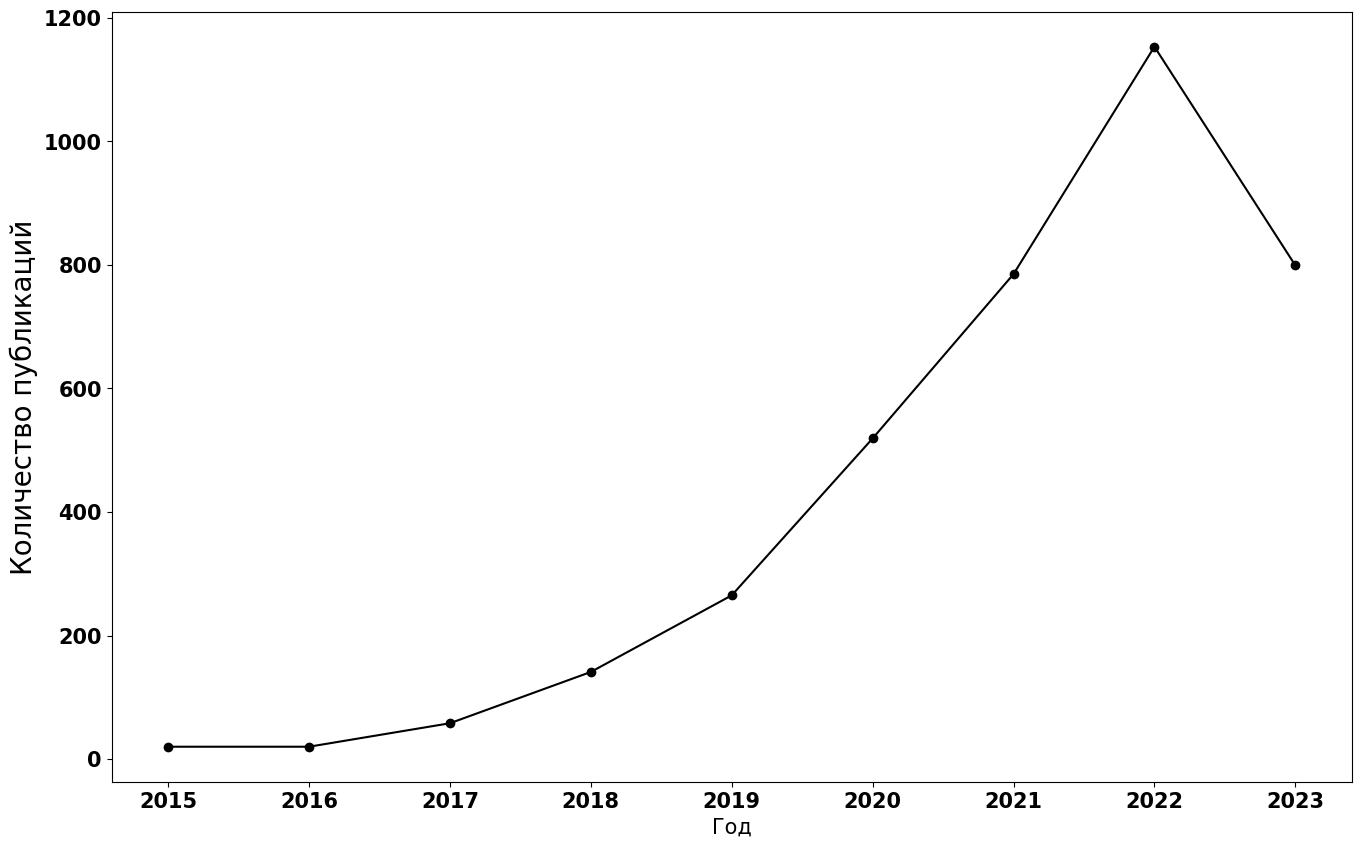

In [79]:
import matplotlib.pyplot as plt

import csv
import os
import json

years = []
citiations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    years.append(row['Год'])
    citiations.append(row['Цитирования'])

# years data
year_data = {}
for year in years:
  if year in year_data:
    year_data[year] += 1
  else:
    year_data[year] = 1

keys = list(year_data.keys())
keys.sort()
sorted_year_data = {i: year_data[i] for i in keys}

years = list(sorted_year_data.keys())[10:]
values = list(sorted_year_data.values())[10:]

font = {'size'   : 15}

plt.rc('font', **font)


fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=15)
axs.set_ylabel('Количество публикаций', fontsize=20)
axs.plot(years, values, '-ok')


Text(0, 0.5, 'Количество публикаций')

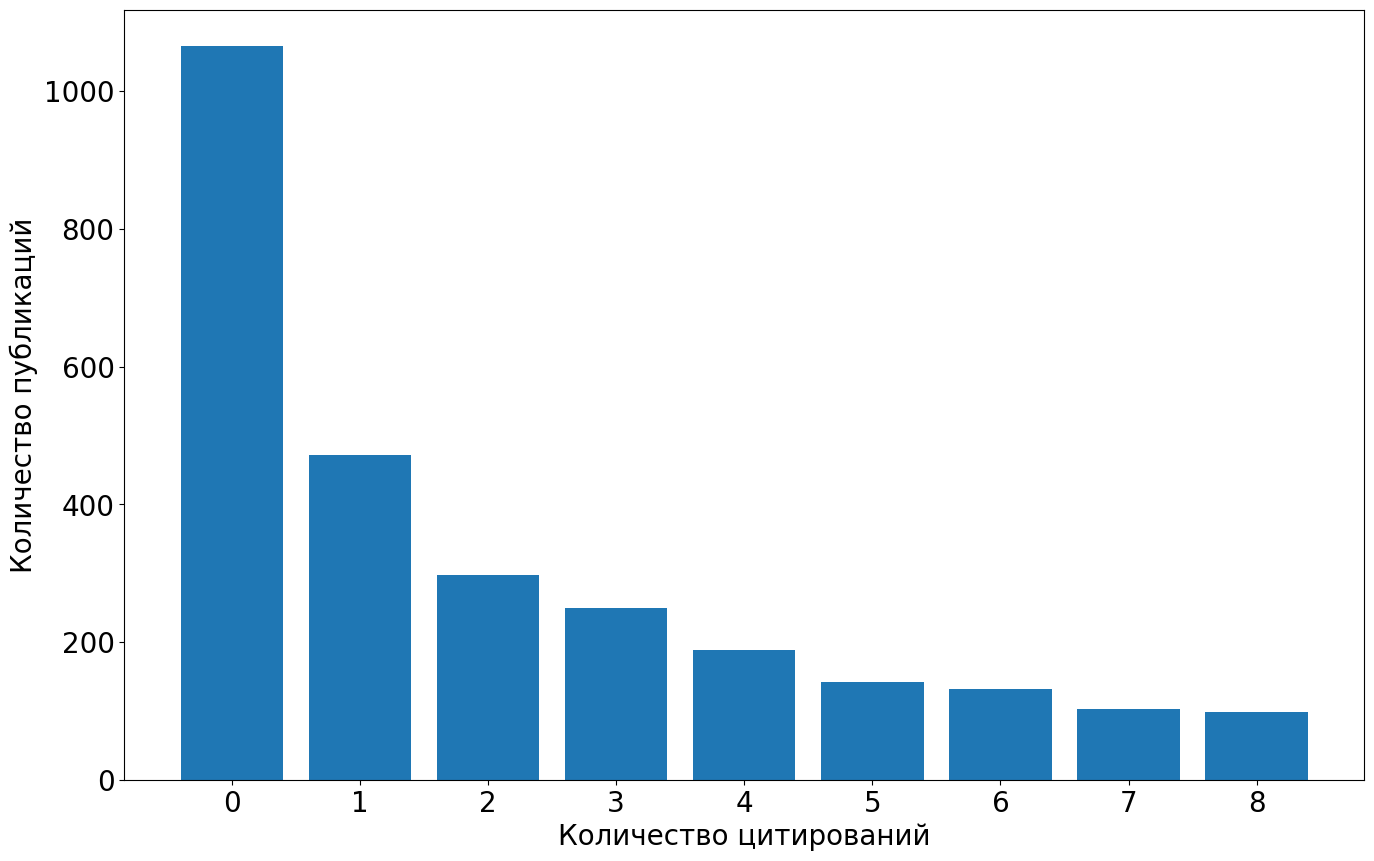

In [45]:
# citiations histogram
citiation_data = {}
for cit in citiations:
  if cit in citiation_data:
    citiation_data[cit] += 1
  else:
    citiation_data[cit] = 1
keys = sorted([int(i) for i in citiation_data.keys()][:9])

vals = []
for key in keys:
  vals.append(citiation_data[str(key)])


fig, axs = plt.subplots(1, 1, figsize=(16, 10))
axs.bar(keys, vals, align='center')
axs.set_xticks(keys)
axs.set_xlabel('Количество цитирований', fontsize=20)
axs.set_ylabel('Количество публикаций', fontsize=20)


[(' China', 1103), (' United States', 527), (' India', 272), (' Brazil', 144), (' Italy', 128), (' Indonesia', 127), (' Canada', 96), (' Australia', 92), (' Germany', 86), (' United Kingdom', 86)]
[' China', ' United States', ' India', ' Brazil', ' Italy', ' Indonesia', ' Canada', ' Australia', ' Germany', ' United Kingdom']
[1103, 527, 272, 144, 128, 127, 96, 92, 86, 86]


Text(0, 0.5, 'Количество публикаций')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

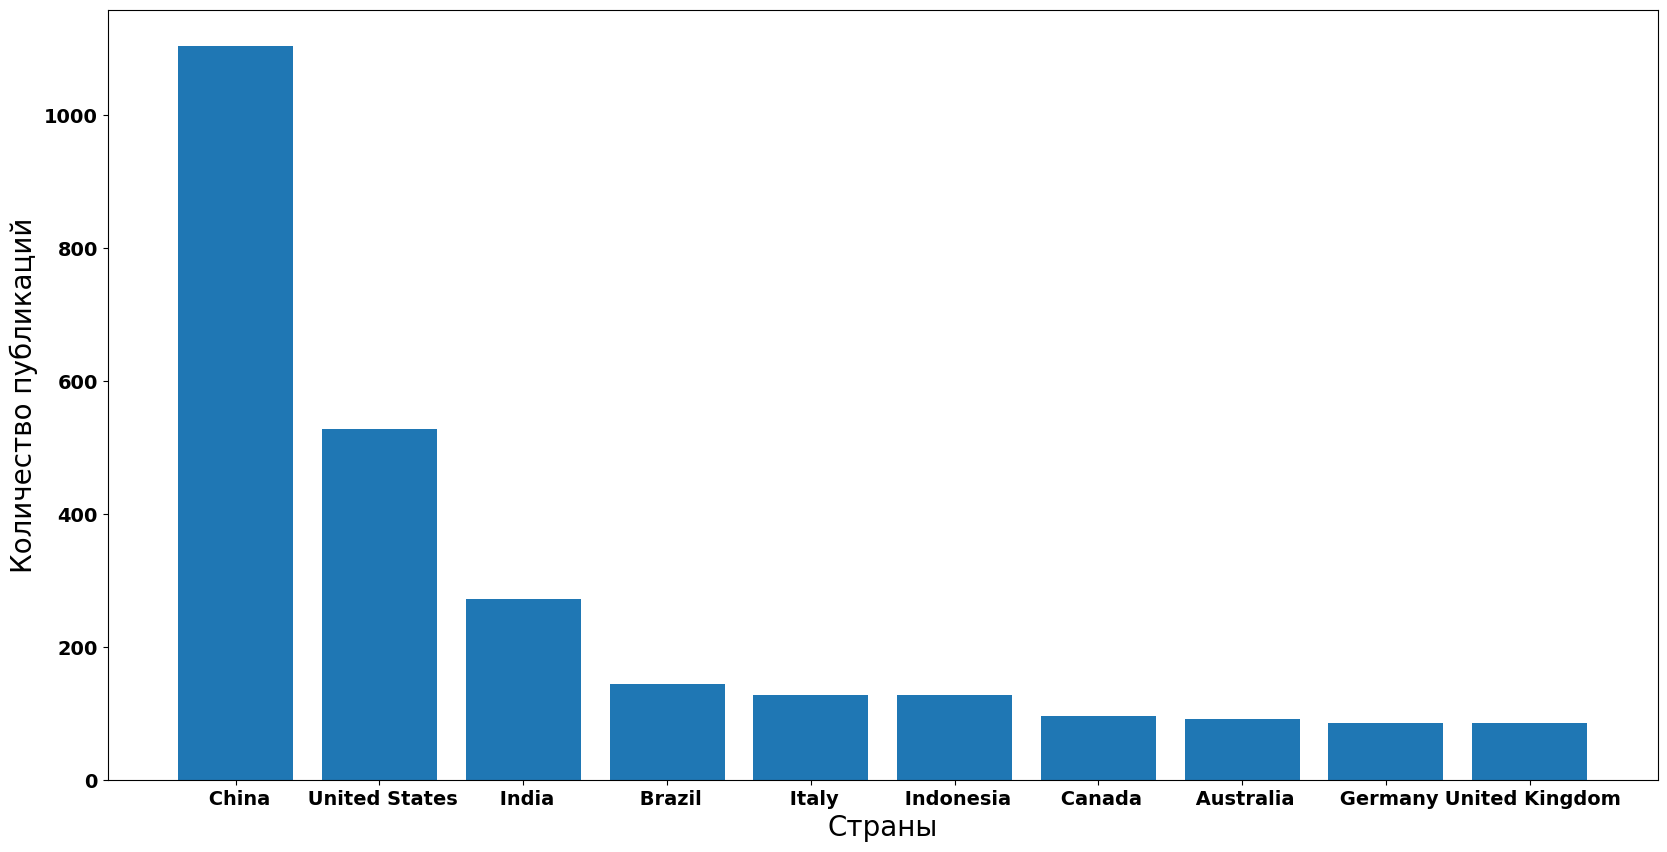

In [92]:
# Страны
import matplotlib.pyplot as plt

import csv

organizations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    organizations.append(row['Организации'])

countries = {}
for org in organizations:
  org_arr = org.split(',') 
  country = org_arr[-1]
  if country in countries:
    countries[country] += 1
  else:
    countries[country] = 1

ranking = sorted(countries.items(), key=lambda x: x[1], reverse=True)[:10]

keys = [i[0] for i in ranking]
vals = [i[1] for i in ranking]

font = {'size'   : 14}

plt.rc('font', **font)


fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.bar(keys, vals, align='center')
axs.set_xticks(keys)
axs.set_xlabel('Страны', fontsize=20)
axs.set_ylabel('Количество публикаций', fontsize=20)



[2015 2016 2017 2018 2019 2020 2021 2022]
[20, 20, 58, 141, 265, 519, 785, 1153]


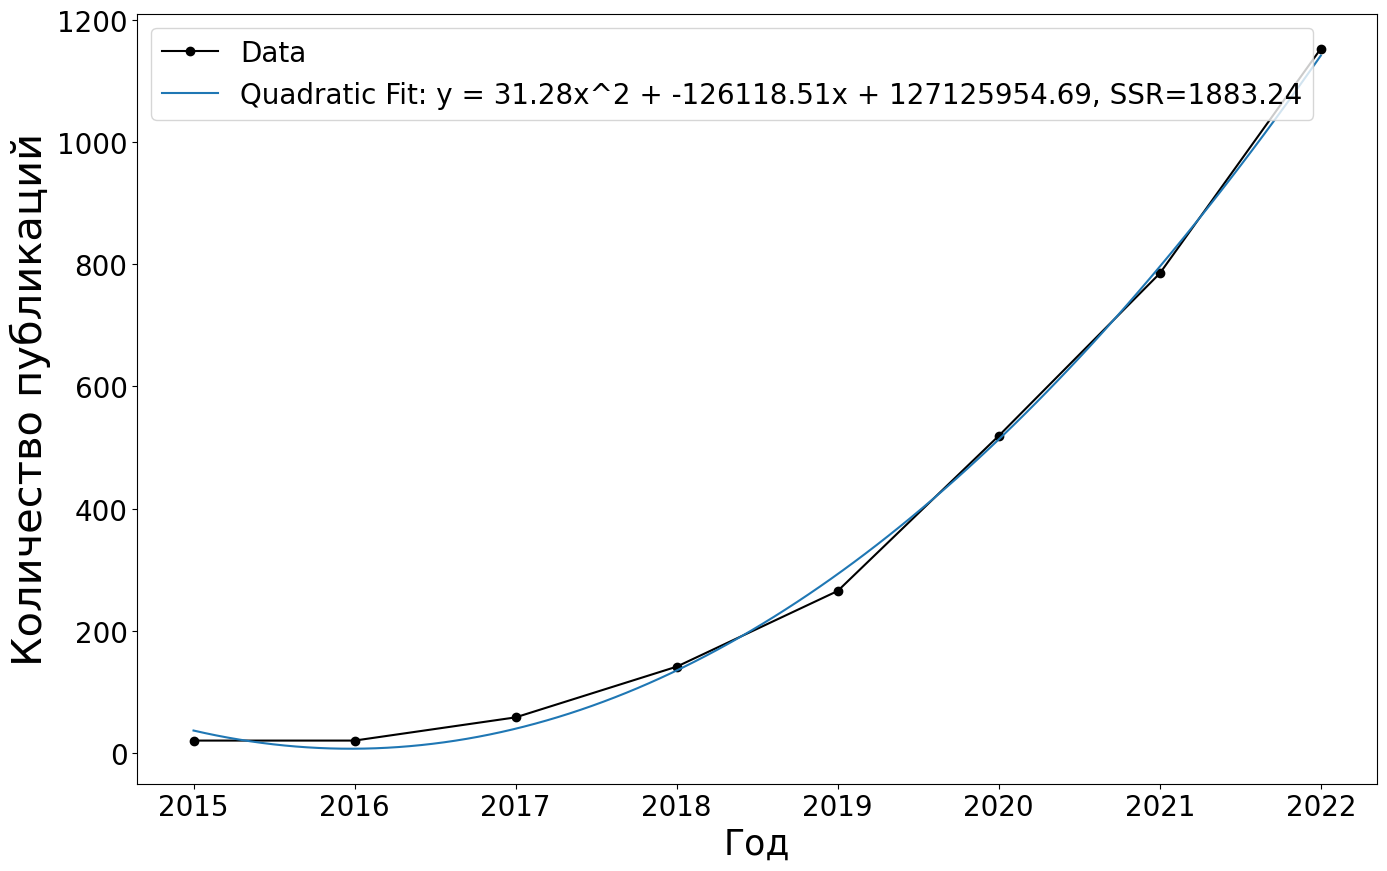

In [42]:
import matplotlib.pyplot as plt

import csv
from scipy.optimize import curve_fit

years = []
citiations = []
with open("./scopus_GEE.csv", 'r') as file:
  csvreader = csv.DictReader(file)
  for row in csvreader:
    years.append(row['Год'])
    citiations.append(row['Цитирования'])

year_data = {}
for year in years:
  if year in year_data:
    year_data[year] += 1
  else:
    year_data[year] = 1

keys = list(year_data.keys())
keys.sort()
sorted_year_data = {int(i): year_data[i] for i in keys}

years = list(sorted_year_data.keys())[10:-1]
values = list(sorted_year_data.values())[10:-1]

years = np.array(years)

print(years)
print(values)
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

params_quad, _ = curve_fit(quadratic_model, years, values)

x_fit = np.linspace(min(years), max(years), 100)

y_fit_quad = quadratic_model(x_fit, *params_quad)

residuals_quad = values - quadratic_model(years, *params_quad)
ssr_quad = np.sum(residuals_quad**2)

font = {'size'   : 20}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 1, figsize=(16, 10), sharey=True)
axs.set_xlabel('Год', fontsize=25)
axs.set_ylabel('Количество публикаций', fontsize=30)
axs.plot(years, values, '-ok', label='Data')

plt.plot(x_fit, y_fit_quad, label=f'Quadratic Fit: y = {params_quad[0]:.2f}x^2 + {params_quad[1]:.2f}x + {params_quad[2]:.2f}, SSR={ssr_quad:.2f}')

axs.legend()


In [44]:
from sklearn.metrics import r2_score

r2_fit = r2_score(values, quadratic_model(years, *params_quad))

print(f"R-squared: {r2_fit:.2f}")


R-squared: 1.00
